## Import packages:

* Pandas
* NumPy
* Matplotlib [(See page)](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/)
* Seaborn
* Scipy 
    * stats
* Sklearn: 
    * ensemble
        * IsolationForest
        * RandomForestClassifier
    * feature_selection
        * SelectFromModel
    * model_selection 
        * train_test_split
    * metrics
     
        

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import matplotlib.cm as cm
import sklearn
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV



In [2]:
data=pd.read_csv("/Users/Cristy/Downloads/task2/X_train.csv")
labels=pd.read_csv("/Users/Cristy/Downloads/task2/y_train.csv")
data['labels']=pd.Series(labels['y'])
data.drop(columns='id',inplace=True)

In [3]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x991,x992,x993,x994,x995,x996,x997,x998,x999,labels
0,-1.099144,0.918165,-1.227394,0.887061,1.182734,-0.371802,-0.127331,1.201702,1.825839,2.944655,...,1.566261,-1.656656,-0.412988,2.803183,-3.253815,-2.042599,3.497246,-1.275422,2.440708,1
1,0.366477,0.933802,0.061234,0.430073,1.029673,-0.613771,0.364698,1.140867,0.182811,-0.344876,...,-0.003721,-0.496326,0.672818,-0.546066,-0.227112,0.291441,-0.150495,0.156421,0.714252,0
2,-0.425879,-0.802152,0.002718,0.820036,1.490237,-0.888121,0.769524,1.059020,0.854806,-0.077359,...,-0.085724,-0.557461,-0.091904,-0.123858,0.387162,1.031941,0.766522,0.339105,-0.046364,1
3,0.822922,-0.843041,-0.734624,-0.000040,0.123783,-1.777226,0.364601,0.425521,1.265122,0.734897,...,1.271367,-1.518161,-0.315441,0.218074,-1.880067,-0.495170,1.418946,-0.201938,1.475484,1
4,-0.285342,-0.641116,0.436524,-0.618663,0.319982,-1.160489,0.528379,0.337300,-0.156210,-0.756133,...,-1.008573,-0.404263,0.304188,0.313034,-0.514287,0.701526,0.473238,-0.046099,0.492881,1


### Missing values

In [53]:
data.isnull().sum()[data.isnull().sum()!=0] # no missing values

Series([], dtype: int64)

### Class distribution

In [5]:
data.groupby('labels').count().mean(axis=1)

labels
0     600.0
1    3600.0
2     600.0
dtype: float64

In [3]:
std_data=data.loc[:,~data.columns.isin(['labels'])].apply(lambda x: (x-x.mean())/x.std())
std_data['labels']=data['labels']



In [14]:
def vectorsLDA(data,new_dim):
    grouped= data.groupby('labels')
    classes=[c for c in grouped.groups.keys()]
    class_data={}
    for c in classes:
        class_data[c]=grouped.get_group(c)
    means={}
    for c in classes:
        means[c]=class_data[c].drop(columns='labels').mean(axis=0)
    overall_means=data.drop(columns='labels').mean(axis=0)
    S_B=np.zeros((data.shape[1]-1,data.shape[1]-1))
    for c in classes:
        S_B += np.multiply(len(class_data[c]),np.outer(means[c]-overall_means,means[c]-overall_means))
    S_W = np.zeros(S_B.shape)
    for c in classes:
        tmp = np.subtract(class_data[c].drop(columns='labels').T, np.expand_dims(means[c], axis=1))
        S_W = np.add(np.dot(tmp, tmp.T), S_W)
    Jw=np.dot(np.linalg.pinv(S_W),S_B)
    eigvals, eigvecs = np.linalg.eig(Jw)
    eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]
    eiglist=sorted(eiglist, key= lambda x:x[0], reverse=True)
    w = np.array([eiglist[i][1] for i in range(new_dim)])
    return w

def KfoldLDA_w(splits,data,new_dim): #labeled data
    kf=KFold(splits,shuffle=False)
    folds=kf.split(data)
    vecs={}
    proj={}
    d=0
    for train_index, test_index in folds:
        vecs[d]=vectorsLDA(data.iloc[train_index],new_dim)
        proj[d]=np.dot(vecs[d],np.array(data.iloc[train_index].drop(columns='labels')).T)
        d+=1
    return(vecs,proj)
    

        
    
    
    
#df=pd.DataFrame({'a':[1,2,3,4,5,6],'b':[7,8,9,10,11,12],'c':[13,14,15,16,17,18],'d':[19,20,21,22,23,24],'labels':[0,0,1,1,2,2]})
#KfoldLDA_w(3,df)





In [8]:
sme = SMOTEENN(random_state=42)
X=std_data.drop(columns='labels')
y=std_data['labels']
X_res, y_res = sme.fit_resample(X, y)
std_data2=pd.DataFrame(X_res)
std_data2['labels']=pd.Series(y_res)
std_data2.groupby('labels').count().mean(axis=1)

labels
0    3570.0
1    1581.0
2    3580.0
dtype: float64

In [9]:
from collections import Counter
print(sorted(Counter(y_res).items()))

[(0, 3570), (1, 1581), (2, 3580)]


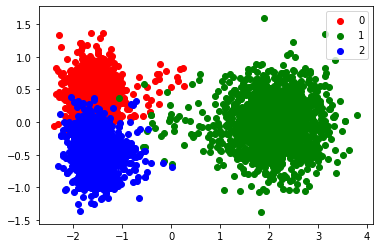

In [13]:
lda=vectorsLDA(std_data2)
lda=lda.real
proj=np.dot(lda,np.array(std_data2.drop(columns='labels')).T)

proj_data=pd.DataFrame(proj.T)
proj_data['labels']=std_data2['labels']

plt.scatter(proj_data[proj_data['labels']==0][0],proj_data[proj_data['labels']==0][1],c='r',label='0')
plt.scatter(proj_data[proj_data['labels']==1][0],proj_data[proj_data['labels']==1][1],c='g',label='1')
plt.scatter(proj_data[proj_data['labels']==2][0],proj_data[proj_data['labels']==2][1],c='b',label='2')
plt.legend()
plt.show()

In [22]:
proj_data[proj_data['labels'].isin([0,2])][0]

0      -1.655000
1      -1.612746
2      -1.627450
3      -1.712006
4      -1.255175
          ...   
8726   -1.647813
8727   -1.309006
8728   -0.688409
8729   -1.406993
8730   -1.593943
Name: 0, Length: 7150, dtype: float64

<IPython.core.display.Javascript object>


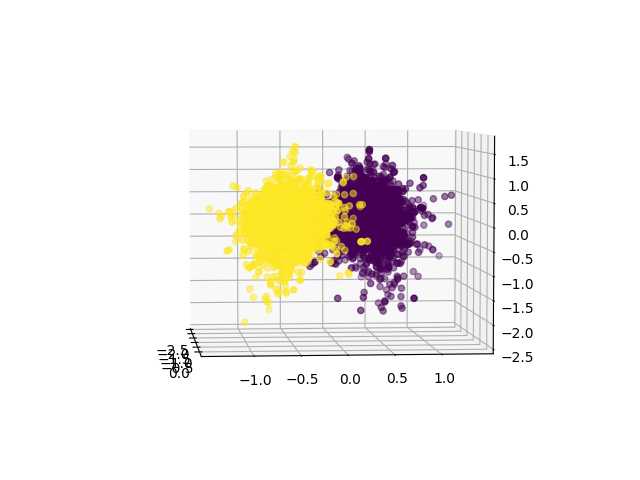

In [23]:
lda3=vectorsLDA(std_data2,3)
lda3=lda3.real
proj=np.dot(lda3,np.array(std_data2.drop(columns='labels')).T)

proj_data=pd.DataFrame(proj.T)
proj_data['labels']=std_data2['labels']



%matplotlib notebook

ax = plt.axes(projection='3d')


xdata = proj_data[proj_data['labels'].isin([0,2])][0]
ydata = proj_data[proj_data['labels'].isin([0,2])][1]
zdata = proj_data[proj_data['labels'].isin([0,2])][2]
ax.scatter3D(xdata, ydata, zdata, c=proj_data[proj_data['labels'].isin([0,2])]['labels']);

#plt.show()

<IPython.core.display.Javascript object>


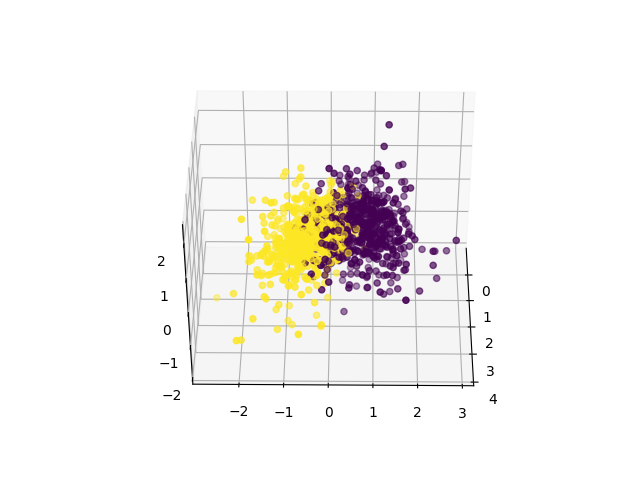

In [24]:
lda4=vectorsLDA(std_data,3)
lda4=lda4.real
proj=np.dot(lda4,np.array(std_data.drop(columns='labels')).T)

proj_data=pd.DataFrame(proj.T)
proj_data['labels']=std_data['labels']



from mpl_toolkits import mplot3d
%matplotlib notebook

ax = plt.axes(projection='3d')


xdata = proj_data[proj_data['labels'].isin([0,2])][0]
ydata = proj_data[proj_data['labels'].isin([0,2])][1]
zdata = proj_data[proj_data['labels'].isin([0,2])][2]
ax.scatter3D(xdata, ydata, zdata, c=proj_data[proj_data['labels'].isin([0,2])]['labels']);

In [8]:
sme2 = SMOTE(ratio='not majority')
X=std_data.drop(columns='labels')
y=std_data['labels']
X_res2, y_res2 = sme2.fit_resample(X, y)
print(sorted(Counter(y_res2).items()))

[(0, 3600), (1, 3600), (2, 3600)]


In [10]:
data2=pd.DataFrame(X_res2)
data2['labels']=pd.Series(y_res2)
lda=vectorsLDA(data2)
proj=np.dot(lda,np.array(data2.drop(columns='labels')).T)

In [18]:
new_data=pd.DataFrame(proj.T)
new_data['labels']=data2.labels
new_data.head()


numpy.int64

/Users/Cristy/.virtualenvs/myenv/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


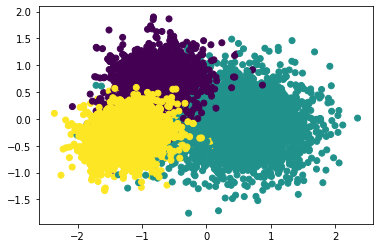

In [21]:
new_data.columns=['lda0','lda1','labels']
plt.scatter(new_data.lda0,new_data.lda1,c=new_data.labels)
plt.show()

* Divide data: train data and test data
* With train data, do oversampling
* with balanced data, do LDA and get vectors
* Project training (balanced) data to vectors
* Apply SVM
* Get scores for train data and test data



In [30]:
X=std_data.drop(columns='labels')
y=std_data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 



sme2 = SMOTE(ratio='not majority')
X_res2, y_res2 = sme2.fit_resample(X_train, y_train)
print(sorted(Counter(y_res2).items()))
data2=pd.DataFrame(X_res2)
data2['labels']=pd.Series(y_res2)
lda=vectorsLDA(data2)
lda=lda.real
proj=np.dot(lda,np.array(data2.drop(columns='labels')).T)
new_data=pd.DataFrame(proj.T)
new_data['labels']=data2.labels

X_train=new_data.drop(columns='labels')
y_train=new_data['labels']
svm_model = svm.SVC(kernel = 'rbf',gamma='scale').fit(X_train, y_train) 



proj=np.dot(lda,np.array(X_test).T)
X_test=pd.DataFrame(proj.T)
svm_predictions = svm_model.predict(X_train)
balanced_accuracy_score(y_train, svm_predictions)









[(0, 2696), (1, 2696), (2, 2696)]


0.9454747774480712

In [45]:
### cross-validation
def cv(data,score):
    kf=KFold(10,shuffle=True)
    folds=kf.split(data)
    train_scores=[]
    test_scores=[]
    for train_index, test_index in folds:
        #Training
        train_data=data.iloc[train_index]
        X_train=train_data.drop(columns='labels')
        y_train=train_data['labels']
        sme2=SMOTE(ratio='not majority')
        X,y=sme2.fit_resample(X_train,y_train)
        train_data=pd.DataFrame(X)
        train_data['labels']=pd.Series(y)
        w=vectorsLDA(train_data)
        w=w.real
        proj=np.dot(w,np.array(train_data.drop(columns='labels')).T)
        new_X_train=pd.DataFrame(proj.T)
        new_y_train=train_data['labels']
        svm_model = svm.SVC(kernel = 'rbf',gamma='scale').fit(new_X_train, new_y_train) 
        train_preds=svm_model.predict(new_X_train)
        res=score(new_y_train,train_preds)
        train_scores.append(res)
        
        #Testing
        test_data=data.iloc[test_index]
        X_test=test_data.drop(columns='labels')
        y_test=test_data['labels']
        proj_test=np.dot(w,np.array(X_test).T)
        new_X_test=pd.DataFrame(proj_test.T)
        test_preds=svm_model.predict(new_X_test)
        res_test=score(y_test,test_preds)
        test_scores.append(res_test)
    return train_scores, test_scores
        
scores=cv(std_data,balanced_accuracy_score)




In [49]:
np.mean(scores[1])

0.6318003892847684

In [29]:
def cv2(data,score): # doing lda before oversampling
    train_scores=[]
    test_scores=[]
    kf=KFold(10,shuffle=True)
    folds=kf.split(data)
    for train_index, test_index in folds:
        train_data=data.iloc[train_index]
        test_data=data.iloc[test_index]
        X_train=train_data.drop(columns='labels')
        y_train=train_data['labels']
        X_test=test_data.drop(columns='labels')
        y_test=test_data['labels']
        
        w=vectorsLDA(train_data)
        w=w.real
        proj=np.dot(w,np.array(X_train).T)
        X=pd.DataFrame(proj.T)
        sme2=SMOTE(ratio='not majority')
        new_X_train,new_y_train=sme2.fit_resample(X,y_train)
        
        svm_model = svm.SVC(kernel = 'rbf',gamma='scale').fit(new_X_train, new_y_train) 
        train_preds=svm_model.predict(new_X_train)
        res=score(new_y_train,train_preds)
        train_scores.append(res)
        
        proj_test=np.dot(w,np.array(X_test).T)
        X_test=pd.DataFrame(proj_test.T)
        test_preds=svm_model.predict(X_test)
        res_test=score(y_test,test_preds)
        test_scores.append(res_test)
    return train_scores, test_scores
        
        
scores2=cv2(std_data,balanced_accuracy_score)        

In [40]:
scores2[1]

[0.6729061266912745,
 0.6348257294247178,
 0.6490275138356036,
 0.6490417473176094,
 0.6697127834114136,
 0.6732626346824735,
 0.6378654075729284,
 0.6724513811470333,
 0.6425974167731398,
 0.6923344610655965]

In [39]:
np.mean(scores2[1])

0.6594025201921789

In [41]:
y=std_data['labels']
w=vectorsLDA(std_data)
w=w.real
proj=np.dot(w,np.array(std_data.drop(columns='labels')).T)
X=pd.DataFrame(proj.T)
sme2=SMOTE(ratio='not majority')
new_X_train,new_y_train=sme2.fit_resample(X,y)
svm_model = svm.SVC(kernel = 'rbf',gamma='scale').fit(new_X_train, new_y_train) 


test=pd.read_csv("/Users/Cristy/Downloads/task2/X_test.csv")
test.drop(columns='id',inplace=True)
std_test=test.apply(lambda x: (x-x.mean())/x.std())
proj_test=np.dot(w,np.array(test).T)
X_test=pd.DataFrame(proj_test.T)
test_preds=svm_model.predict(X_test)




output = pd.DataFrame({'id':[float(i) for i in range(0,len(test_preds))],'y':test_preds})
output.to_csv("sampletask2.csv",index=False)

In [36]:
def cv3(data,score): # using 'class_weight'
    train_scores=[]
    test_scores=[]
    kf=KFold(10,shuffle=True)
    folds=kf.split(data)
    for train_index, test_index in folds:
        train_data=data.iloc[train_index]
        test_data=data.iloc[test_index]
        X_train=train_data.drop(columns='labels')
        y_train=train_data['labels']
        X_test=test_data.drop(columns='labels')
        y_test=test_data['labels']
        
        w=vectorsLDA(train_data)
        w=w.real
        proj=np.dot(w,np.array(X_train).T)
        X_train=pd.DataFrame(proj.T)
        
        
        svm_model = svm.SVC(kernel = 'rbf',gamma='scale',class_weight='balanced').fit(X_train, y_train) 
        train_preds=svm_model.predict(X_train)
        res=score(y_train,train_preds)
        train_scores.append(res)
        
        proj_test=np.dot(w,np.array(X_test).T)
        X_test=pd.DataFrame(proj_test.T)
        test_preds=svm_model.predict(X_test)
        res_test=score(y_test,test_preds)
        test_scores.append(res_test)
    return train_scores, test_scores

scores3=cv3(std_data,balanced_accuracy_score)     


In [37]:
np.mean(scores3[1])

0.6550717150326935

In [43]:
def cv4(data,score): # doing lda before oversampling with random oversampling
    train_scores=[]
    test_scores=[]
    kf=KFold(10,shuffle=True)
    folds=kf.split(data)
    for train_index, test_index in folds:
        train_data=data.iloc[train_index]
        test_data=data.iloc[test_index]
        X_train=train_data.drop(columns='labels')
        y_train=train_data['labels']
        X_test=test_data.drop(columns='labels')
        y_test=test_data['labels']
        
        w=vectorsLDA(train_data)
        w=w.real
        proj=np.dot(w,np.array(X_train).T)
        X=pd.DataFrame(proj.T)
        sme2=RandomOverSampler()
        new_X_train,new_y_train=sme2.fit_resample(X,y_train)
        
        svm_model = svm.SVC(kernel = 'rbf',gamma='scale').fit(new_X_train, new_y_train) 
        train_preds=svm_model.predict(new_X_train)
        res=score(new_y_train,train_preds)
        train_scores.append(res)
        
        proj_test=np.dot(w,np.array(X_test).T)
        X_test=pd.DataFrame(proj_test.T)
        test_preds=svm_model.predict(X_test)
        res_test=score(y_test,test_preds)
        test_scores.append(res_test)
    return train_scores, test_scores
        
        
scores4=cv4(std_data,balanced_accuracy_score)

In [44]:
np.mean(scores4[1])

0.6556138348725634

In [8]:
kf=KFold(10,shuffle=True)
folds=kf.split(std_data)
c=0
w={}
for train_index,test_index in folds:
    train_data=std_data.iloc[train_index]
    w[c]=vectorsLDA(train_data)
    c+=1

In [18]:
for i in range(len(w)):
    w[i] = w[i].real

In [21]:
w[0]

array([[ 0.06869078,  0.02595331,  0.0549974 , ...,  0.06683656,
         0.00121287,  0.04016718],
       [-0.03661335, -0.01223198,  0.02718832, ...,  0.02153618,
        -0.02214309, -0.04430027]])

In [24]:
len(w[0][0])

1000

In [ ]:
# training a linear SVM classifier 
from sklearn.svm import SVC 
svm_model = SVC(kernel = 'rbf', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model.predict(X_test)

In [ ]:
classes = [0,1,2]
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
plotlabels = {classes[c] : colors[c] for c in range(len(classes))}



kf=KFold(5,shuffle=False)
folds=kf.split(data2)
vecs={}
proj={}
d=0
for train_index, test_index in folds:
    dat=data2.iloc[train_index]
    vecs[d]=vectorsLDA(dat)
    fig = plt.figure()
    for i, row in dat.iterrows():
        proj = np.dot(vecs[d], row[:len(dat.columns)-1])
        plt.scatter(proj[0], proj[1], color = plotlabels[row['labels']])
    plt.show()
    d+=1




In [135]:
plotlabels

{0: array([0.5, 0. , 1. , 1. ]),
 1: array([0.50392157, 0.99998103, 0.70492555, 1.        ]),
 2: array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])}

In [142]:
classes = [0,1,2]
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
plotlabels = {classes[c] : colors[c] for c in range(len(classes))}


w=vectorsLDA(data2)




<Figure size 432x288 with 0 Axes>

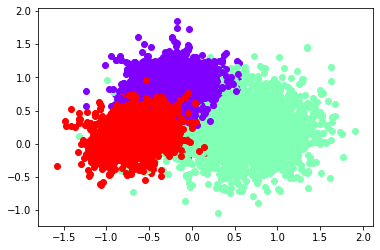

In [143]:
#fig=plt.figure()
#proj=np.dot(w,np.array(data2.drop(columns='labels')).T)
#plt.scatter(proj[0], proj[1], c=labels)
#plt.show()


fig = plt.figure()
for i, row in data2.iterrows():
    proj = np.dot(w, row[:len(data2.columns)-1])
    plt.scatter(proj[0], proj[1], color = 
                plotlabels[row['labels']])
plt.show()

### To Do's:
* Plot 3D projections
* SVM with linear kernel (WITH CLASS WEIGHT)
* Use SMOTEENN --> lda -->  SVM with class weight


### 3 vectors LDA

In [38]:
data=std_data.drop(columns='labels')
labels=std_data.labels

X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.3,random_state=42)
sme=SMOTEENN()
X_res,y_res=sme.fit_resample(X_train,y_train)
train_data_b=pd.DataFrame(X_res)
train_data_b['labels']=pd.Series(y_res)
w=vectorsLDA(train_data_b,3)
w=w.real
proj=np.dot(w,train_data_b.drop(columns='labels').T)
proj_X_train=pd.DataFrame(proj.T)


svm_model = svm.SVC(kernel = 'linear',class_weight='balanced').fit(proj_X_train, y_res) 
svm_model2 = svm.SVC(kernel = 'rbf',gamma='scale',class_weight='balanced').fit(proj_X_train, y_res)
train_preds=svm_model.predict(proj_X_train)
train_score=[]
train_score.append(balanced_accuracy_score(y_res,train_preds))
train_preds=svm_model2.predict(proj_X_train)
train_score.append(balanced_accuracy_score(y_res,train_preds))

    
    
    
proj_test=np.dot(w,np.array(X_test).T)
proj_test_data=pd.DataFrame(proj_test.T)
test_preds=svm_model.predict(proj_test_data)
test_score=[]
test_score.append(balanced_accuracy_score(y_test,test_preds))
test_preds=svm_model2.predict(proj_test_data)
test_score.append(balanced_accuracy_score(y_test,test_preds))

In [39]:
train_score

[0.9946514465527906, 0.9946520906722697]

In [40]:
test_score

[0.6085543113360151, 0.6139750829780382]

### with 2 vectors LDA

In [41]:
data=std_data.drop(columns='labels')
labels=std_data.labels

X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.3,random_state=42)
sme=SMOTEENN()
X_res,y_res=sme.fit_resample(X_train,y_train)
train_data_b=pd.DataFrame(X_res)
train_data_b['labels']=pd.Series(y_res)
w=vectorsLDA(train_data_b,2)
w=w.real
proj=np.dot(w,train_data_b.drop(columns='labels').T)
proj_X_train=pd.DataFrame(proj.T)


svm_model = svm.SVC(kernel = 'linear',class_weight='balanced').fit(proj_X_train, y_res) 
svm_model2 = svm.SVC(kernel = 'rbf',gamma='scale',class_weight='balanced').fit(proj_X_train, y_res)
train_preds=svm_model.predict(proj_X_train)
train_score=[]
train_score.append(balanced_accuracy_score(y_res,train_preds))
train_preds=svm_model2.predict(proj_X_train)
train_score.append(balanced_accuracy_score(y_res,train_preds))

    
    
    
proj_test=np.dot(w,np.array(X_test).T)
proj_test_data=pd.DataFrame(proj_test.T)
test_preds=svm_model.predict(proj_test_data)
test_score=[]
test_score.append(balanced_accuracy_score(y_test,test_preds))
test_preds=svm_model2.predict(proj_test_data)
test_score.append(balanced_accuracy_score(y_test,test_preds))

In [42]:
train_score

[0.9954513079617388, 0.9953175465920223]

In [43]:
test_score

[0.6401937819771559, 0.6374491961990355]

In [72]:
data=std_data.drop(columns='labels')
labels=std_data.labels

X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.3,random_state=42)
train_data=pd.DataFrame(X_train)
train_data['labels']=y_train
w=vectorsLDA(train_data,2)
w=w.real
proj=np.dot(w,train_data.drop(columns='labels').T)
proj_X_train=pd.DataFrame(proj.T)


svm_model = svm.SVC(kernel = 'linear',class_weight='balanced').fit(proj_X_train, y_train) 
svm_model2 = svm.SVC(kernel = 'rbf',gamma='scale',class_weight='balanced').fit(proj_X_train, y_train)
train_preds=svm_model.predict(proj_X_train)
train_score=[]
train_score.append(balanced_accuracy_score(y_train,train_preds))
train_preds=svm_model2.predict(proj_X_train)
train_score.append(balanced_accuracy_score(y_train,train_preds))

    
    
    
proj_test=np.dot(w,np.array(X_test).T)
proj_test_data=pd.DataFrame(proj_test.T)
test_preds=svm_model.predict(proj_test_data)
test_score=[]
test_score.append(balanced_accuracy_score(y_test,test_preds))
test_preds=svm_model2.predict(proj_test_data)
test_score.append(balanced_accuracy_score(y_test,test_preds))

In [73]:
y_train.shape

(3360,)

In [48]:
train_score

[0.8715917034322649, 0.8736089776990688]

In [49]:
test_score

[0.6567428745252207, 0.6543100103745099]

## 2 vectors LDA --> SMOTEENN 

In [59]:
X_train.T.shape

(1000, 3360)

In [77]:
data=std_data.drop(columns='labels')
labels=std_data.labels

X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.3,random_state=42)
train_data=pd.DataFrame(X_train)
train_data['labels']=y_train
w=vectorsLDA(train_data,2)
w=w.real
proj=np.dot(w,np.array(train_data.drop(columns='labels')).T)
proj_X_train=pd.DataFrame(proj.T)

sme=SMOTEENN()
X_train_new,y_train_new=sme.fit_resample(proj_X_train,y_train)


svm_model = svm.SVC(kernel = 'linear',class_weight='balanced').fit(X_train_new, y_train_new) 
svm_model2 = svm.SVC(kernel = 'rbf',gamma='scale',class_weight='balanced').fit(X_train_new, y_train_new)
train_preds=svm_model.predict(X_train_new)
train_score=[]
train_score.append(balanced_accuracy_score(y_train_new,train_preds))
train_preds=svm_model2.predict(X_train_new)
train_score.append(balanced_accuracy_score(y_train_new,train_preds))

    
    
    
proj_test=np.dot(w,np.array(X_test).T)
proj_test_data=pd.DataFrame(proj_test.T)
test_preds=svm_model.predict(proj_test_data)
test_score=[]
test_score.append(balanced_accuracy_score(y_test,test_preds))
test_preds=svm_model2.predict(proj_test_data)
test_score.append(balanced_accuracy_score(y_test,test_preds))

In [78]:
train_score

[0.9642327122706654, 0.9674889201993264]

In [79]:
test_score

[0.6565019452402209, 0.651928250058791]

In [69]:
train_preds.shape

(6115,)

In [70]:
y_train_new.shape

(6115,)

### PCA

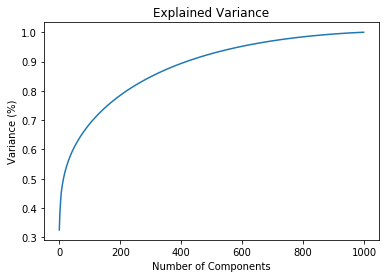

In [7]:
pca = PCA().fit(std_data.drop(columns='labels'))
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

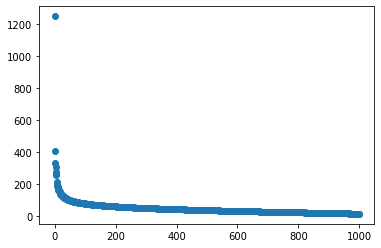

In [11]:
plt.scatter(range(len(pca.singular_values_)),pca.singular_values_)
plt.show()

In [12]:
pca.singular_values_

array([1248.82898435,  406.70874299,  333.29525757,  304.40734568,
        278.61642295,  268.50231376,  257.90813531,  214.38008627,
        195.64803094,  187.46717431,  182.09727978,  178.94137984,
        163.17010613,  161.26994845,  154.79746368,  154.05013715,
        151.21954741,  150.16032376,  144.5596599 ,  140.60297209,
        135.87163395,  134.23213824,  132.94164868,  129.62273004,
        128.99044562,  126.8178581 ,  124.9609984 ,  123.68943799,
        122.34420464,  121.47721924,  117.77358659,  116.81048204,
        115.331818  ,  115.05949221,  114.15000597,  112.87222853,
        112.07865664,  110.51980438,  109.00021027,  107.95055697,
        106.73950037,  106.13867287,  104.43428242,  103.43351007,
        102.84518646,  102.1647339 ,  101.63811024,  100.9797005 ,
        100.42044194,   99.25335178,   98.10836791,   97.9792728 ,
         96.53805313,   96.45302839,   96.16998919,   95.68719265,
         95.18844321,   94.28238764,   93.30295098,   93.07915

* Apply PCA to train data n_components=0.8
* Apply LDA
* Use SVM rbf with class weights


In [20]:
train_data_pca.shape

(3840, 217)

### Model

In [30]:
pca = PCA(n_components = 0.8)
data=std_data.drop(columns='labels')
labels=std_data['labels']

X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2)

pca.fit(X_train)
train_data_pca = pd.DataFrame(pca.transform(X_train))
train_data_pca['labels']=pd.Series(y_train)

#w=vectorsLDA(train_data_pca,2)
#w=w.real
#proj=np.dot(w,np.array(train_data_pca.drop(columns='labels')).T)
#proj_train_data=pd.DataFrame(proj.T)

svm_mod=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(train_data_pca.drop(columns='labels'),y_train)
train_pred=svm_mod.predict(train_data_pca.drop(columns='labels'))
train_score=balanced_accuracy_score(y_train,train_pred)


test_data_pca=pd.DataFrame(pca.transform(X_test))
#proj=np.dot(w,np.array(test_data_pca).T)
#proj_test_data=pd.DataFrame(proj.T)

test_pred=svm_mod.predict(test_data_pca)
test_score=balanced_accuracy_score(y_test,test_pred)



In [20]:
pca = PCA(n_components = 0.8)
## Cross-validation
data=std_data.drop(columns='labels')
labels=std_data.labels
kf=KFold(10,shuffle=True)
folds=kf.split(data)
i=0
test_scores=[]
train_scores=[]
for train_index, test_index in folds:
    X_train=data.values[train_index]
    X_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    pca.fit(pd.DataFrame(X_train))
    X_trainpca=pca.transform(pd.DataFrame(X_train))
    svm_mod=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(X_trainpca,y_train)
    train_pred=svm_mod.predict(X_trainpca)
    train_score=balanced_accuracy_score(y_train,train_pred)
    train_scores.append(train_score)
    i+=1
    print("Fold: {}\n Train score: {}".format(i,train_score))
    X_testpca=pca.transform(X_test)
    test_pred=svm_mod.predict(X_testpca)
    test_score=balanced_accuracy_score(y_test,test_pred)
    print("Test score: {}".format(test_score))
    test_scores.append(test_score)
    
print("Mean train score: {}\n Mean test score:{}".format(np.mean(train_score),np.mean(test_score)))

    
    
    
    


Fold: 1
 Train score: 0.8474866246932491
Test score: 0.6579097985347986
Fold: 2
 Train score: 0.8466717013607153
Test score: 0.6750726442507263
Fold: 3
 Train score: 0.8410474183333577
Test score: 0.7153448359189986
Fold: 4
 Train score: 0.8418984828974466
Test score: 0.7039344359753273
Fold: 5
 Train score: 0.8479144618985405
Test score: 0.7159542230200966
Fold: 6
 Train score: 0.8431449512708991
Test score: 0.6839001989121716
Fold: 7
 Train score: 0.845062806118539
Test score: 0.7505776330239723
Fold: 8
 Train score: 0.8497208434848882
Test score: 0.6855667170874865
Fold: 9
 Train score: 0.8389461376120205
Test score: 0.7478543919520853
Fold: 10
 Train score: 0.8521335744872651
Test score: 0.6600689758584495
Mean train score: 0.8521335744872651
 Mean test score:0.6600689758584495


In [31]:
train_score

0.8521691290912465

In [32]:
test_score

0.6985539318388155

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
data=std_data.drop(columns='labels')
labels=std_data['labels']
lda = LinearDiscriminantAnalysis()
#X_lda = lda.fit_transform(data, labels)


kf=KFold(n_splits=10,shuffle=True)
folds=kf.split(data)
train_scores=[]
test_scores=[]
i=0
for train_index, test_index in folds:
    X_train=data.values[train_index]
    X_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    X_lda=lda.fit_transform(X_train,y_train)
    dt=DecisionTreeClassifier(class_weight='balanced')
    dt.fit(X_lda,y_train)
    # Training 
    train_preds=dt.predict(X_lda)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    i+=1
    print("Fold {}\n Train score: {}".format(i,trainscore))
    train_scores.append(trainscore)
    # Testing
    X_testlda=lda.transform(X_test)
    test_preds=dt.predict(X_testlda)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score:{}\n Mean test score: {}".format(np.mean(train_scores),np.mean(test_scores)))    
    

#X_train, X_test, y_train, y_test = train_test_split(X_lda, labels, random_state=1)
#dt = DecisionTreeClassifier()
#dt.fit(X_train, y_train)
#y_pred = dt.predict(X_test)
#balanced_accuracy_score(y_test,y_pred)

Fold 1
 Train score: 1.0
Test score:0.5772606478488832
Fold 2
 Train score: 1.0
Test score:0.575955497619177
Fold 3
 Train score: 1.0
Test score:0.5780882713729971
Fold 4
 Train score: 1.0
Test score:0.53239442693984
Fold 5
 Train score: 1.0
Test score:0.5845315505082883
Fold 6
 Train score: 1.0
Test score:0.5429132549812313
Fold 7
 Train score: 1.0
Test score:0.5928691547352805
Fold 8
 Train score: 1.0
Test score:0.5516963994786576
Fold 9
 Train score: 1.0
Test score:0.6150089126559715
Fold 10
 Train score: 1.0
Test score:0.5592972410328158
Mean train score:1.0
 Mean test score: 0.5710015357173143


### Model

In [23]:
data=std_data.drop(columns='labels')
labels=std_data['labels']
#X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=1)
#lda.fit(data,labels)
#X_train_lda=lda.transform(X_train)
#svm1=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced')
#svm1.fit(X_train_lda,y_train)

#train_pred=svm1.predict(X_train_lda)
#print('Train score:', balanced_accuracy_score(y_train,train_pred))

#X_test=lda.transform(X_test)
#test_pred=svm1.predict(X_test)
#print('Test score:', balanced_accuracy_score(y_test,test_pred))



lda = LinearDiscriminantAnalysis()
# Cross validation
kf=KFold(n_splits=10)
folds=kf.split(data)
train_scores=[]
test_scores=[]
i=0
for train_index, test_index in folds:
    x_train=data.values[train_index]
    x_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    x_trainlda=lda.fit_transform(x_train,y_train)
    svm1=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(x_trainlda,y_train)
    
    #training scores
    train_preds=svm1.predict(x_trainlda)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    train_scores.append(trainscore)
    i+=1
    print("Fold {}\n Train score:{}".format(i,trainscore))
    
    #testing scores
    x_testlda=lda.transform(x_test)
    test_preds=svm1.predict(x_testlda)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}\n".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score: {}\n Mean test score:{}".format(np.mean(train_scores),np.mean(test_scores)))
    


Fold 1
 Train score:0.8438700058187393
Test score:0.6414794007490636

Fold 2
 Train score:0.8405394165107358
Test score:0.683135619303984

Fold 3
 Train score:0.8408243247257311
Test score:0.6542144835773644

Fold 4
 Train score:0.8500529678382903
Test score:0.6363714472282366

Fold 5
 Train score:0.841572295814864
Test score:0.6640363548814253

Fold 6
 Train score:0.8368582251794633
Test score:0.689771364146648

Fold 7
 Train score:0.8410508597482367
Test score:0.6418106695174043

Fold 8
 Train score:0.851174842055613
Test score:0.6365676736644478

Fold 9
 Train score:0.8489764989264542
Test score:0.6404360124478196

Fold 10
 Train score:0.8520721578209765
Test score:0.6529865240984362

Mean train score: 0.8446991594439105
 Mean test score:0.654080954961483


In [40]:
std_data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x991,x992,x993,x994,x995,x996,x997,x998,x999,labels
0,-1.840326,1.597233,-1.566715,1.318379,1.224108,0.467427,-0.253549,1.039704,1.633808,4.417618,...,1.888482,-1.162274,-0.364498,3.890447,-2.427068,-2.940528,2.811817,-2.298899,2.524743,1
1,0.619528,1.623244,0.278015,0.514886,0.944344,0.104680,0.645978,0.923262,-0.443695,-0.067931,...,-0.477999,0.175075,1.183244,-2.431837,0.437397,0.129538,-1.352264,0.354308,0.407535,0
2,-0.710338,-1.264436,0.194246,1.200533,1.786156,-0.306610,1.386083,0.766600,0.405999,0.296851,...,-0.601606,0.104613,0.093185,-1.634848,1.018745,1.103551,-0.305443,0.692822,-0.525232,1
3,1.385612,-1.332452,-0.861293,-0.241353,-0.711425,-1.639508,0.645802,-0.445964,0.924818,1.404429,...,1.443979,-1.002650,-0.225451,-0.989392,-1.126956,-0.905126,0.439333,-0.309733,1.341058,1
4,-0.474465,-0.996560,0.815258,-1.329039,-0.352817,-0.714929,0.945220,-0.614826,-0.872365,-0.628714,...,-1.992644,0.281183,0.657787,-0.810138,0.165616,0.668942,-0.640241,-0.020962,0.136061,1


In [47]:

test=pd.read_csv("/Users/Cristy/Downloads/task2/X_test.csv")
test.drop(columns='id',inplace=True)
std_test=test.apply(lambda x: (x-x.mean())/x.std())





In [50]:
X_test=lda.transform(std_test)
test_pred=svm1.predict(X_test)

output = pd.DataFrame({'id':[float(i) for i in range(0,len(test_pred))],'y':test_pred})
output.to_csv("sample2LDASVMtask2.csv",index=False)

### Model

In [75]:





pca = PCA(n_components = 0.8)
data=std_data.drop(columns='labels')
labels=std_data['labels']

X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2)

pca.fit(X_train)
train_data_pca = pd.DataFrame(pca.transform(X_train))


lda = LinearDiscriminantAnalysis()
lda.fit(train_data_pca, y_train)
X_lda = lda.transform(train_data_pca)

svm_mod=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(X_lda,y_train)
train_pred=svm_mod.predict(X_lda)
train_score=balanced_accuracy_score(y_train,train_pred)


test_data=pd.DataFrame(lda.transform((pca.transform(X_test))))


test_pred=svm_mod.predict(test_data)
test_score=balanced_accuracy_score(y_test,test_pred)



In [76]:
train_score

0.753458824822198

In [77]:
test_score

0.6778939203931773

In [24]:
## Cross validation


pca = PCA(n_components = 0.8)
lda=LinearDiscriminantAnalysis()
data=std_data.drop(columns='labels')
labels=std_data['labels']

kf=KFold(n_splits=10,shuffle=True)
folds=kf.split(data)
train_scores=[]
test_scores=[]
i=0
for train_index, test_index in folds:
    x_train=data.values[train_index]
    x_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    pca.fit(x_train)
    x_trainpca=pca.transform(x_train)
    x_pcalda=lda.fit_transform(x_trainpca,y_train)
    svm_mod=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(x_pcalda,y_train)
    
    #training scores
    train_preds=svm_mod.predict(x_pcalda)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    i+=1
    print("Fold {}\n Train score: {}".format(i,trainscore))
    train_scores.append(trainscore)
    
    #testing scores
    x_testpca=pca.transform(x_test)
    x_testpcalda=lda.transform(x_testpca)
    test_preds=svm_mod.predict(x_testpcalda)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}\n".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score: {}\n Mean test score:{}".format(np.mean(train_scores),np.mean(test_scores)))

Fold 1
 Train score: 0.7312829259642667
Test score:0.7076857876823972

Fold 2
 Train score: 0.7313703914582798
Test score:0.6935114152095284

Fold 3
 Train score: 0.7450416383022663
Test score:0.6670848039007242

Fold 4
 Train score: 0.7391056791931403
Test score:0.6422482028483696

Fold 5
 Train score: 0.7309754007265749
Test score:0.6996757434146305

Fold 6
 Train score: 0.7377133979996514
Test score:0.6700286715695905

Fold 7
 Train score: 0.7426423525277434
Test score:0.6563579135313834

Fold 8
 Train score: 0.7330239150629477
Test score:0.6764601064944866

Fold 9
 Train score: 0.743524198353947
Test score:0.6855970030288537

Fold 10
 Train score: 0.7360804561982074
Test score:0.7034987229881923

Mean train score: 0.7370760355787025
 Mean test score:0.6802148370668156


### Model

In [78]:
data=std_data.drop(columns='labels')
labels=std_data.labels
X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2)

model=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(X_train,y_train)
train_preds=model.predict(X_train)
print('train score:', balanced_accuracy_score(y_train,train_preds))

test_preds=model.predict(X_test)
print('test_score:',balanced_accuracy_score(y_test,test_preds))

train score: 0.9085691142175887
test_score: 0.722317186560987


In [26]:
## Cross validation

data=std_data.drop(columns='labels')
labels=std_data.labels

kf=KFold(n_splits=10)
folds=kf.split(data)
train_scores=[]
test_scores=[]
i=0

for train_index, test_index in folds:
    x_train=data.values[train_index]
    x_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    model=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(x_train,y_train)
    
    #training scores
    train_preds=model.predict(x_train)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    i+=1
    print("Fold {}\n Train score: {}".format(i,trainscore))
    train_scores.append(trainscore)
    
    
    #testing scores
    test_preds=model.predict(x_test)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score:{}\n mean test score:{}".format(np.mean(train_scores),np.mean(test_scores)))

Fold 1
 Train score: 0.9161569078387575
Test score:0.6748517478152309
Fold 2
 Train score: 0.9098047821042773
Test score:0.6951700914492595
Fold 3
 Train score: 0.9075345555246769
Test score:0.7271034729681346
Fold 4
 Train score: 0.908215837440178
Test score:0.6908444169502012
Fold 5
 Train score: 0.9099416467862532
Test score:0.6524978933429638
Fold 6
 Train score: 0.9077186932247759
Test score:0.7292024548726048
Fold 7
 Train score: 0.9060687870954572
Test score:0.688989927694105
Fold 8
 Train score: 0.906123145637382
Test score:0.6986089776412356
Fold 9
 Train score: 0.910381932243598
Test score:0.6685721808783381
Fold 10
 Train score: 0.9076594843557194
Test score:0.6892373000140165
Mean train score:0.9089605772251076
 mean test score:0.691507846362609


In [29]:
from sklearn.ensemble import IsolationForest

data=std_data.drop(columns='labels')
labels=std_data.labels

clf = IsolationForest(max_samples=100, random_state=42, behaviour="new",contamination=.1)

clf.fit(std_data.drop(columns='labels'))
y_pred_train = clf.predict(data)
std_data_clean = std_data[np.where(y_pred_train == 1, True, False)]
#std_data_clean.shape



## Cross validation

data=std_data_clean.drop(columns='labels')
labels=std_data_clean.labels

kf=KFold(n_splits=10)
folds=kf.split(data)
train_scores=[]
test_scores=[]
i=0

for train_index, test_index in folds:
    x_train=data.values[train_index]
    x_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    model=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(x_train,y_train)
    
    #training scores
    train_preds=model.predict(x_train)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    i+=1
    print("Fold {}\n Train score: {}".format(i,trainscore))
    train_scores.append(trainscore)
    
    
    #testing scores
    test_preds=model.predict(x_test)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score:{}\n mean test score:{}".format(np.mean(train_scores),np.mean(test_scores)))

Fold 1
 Train score: 0.9216212481371123
Test score:0.6888043382547183
Fold 2
 Train score: 0.9152525784953793
Test score:0.6870630648591175
Fold 3
 Train score: 0.9147707806748397
Test score:0.7166520495312075
Fold 4
 Train score: 0.9133904615768867
Test score:0.6977816594326735
Fold 5
 Train score: 0.914413793158113
Test score:0.6458853274610554
Fold 6
 Train score: 0.9137868148287674
Test score:0.7144770152202772
Fold 7
 Train score: 0.9146834275259902
Test score:0.6753968253968253
Fold 8
 Train score: 0.9108752499711649
Test score:0.6962895914117878
Fold 9
 Train score: 0.9145318023441918
Test score:0.6647375338502386
Fold 10
 Train score: 0.9109129067900205
Test score:0.6942162706901304
Mean train score:0.9144239063502466
 mean test score:0.6881303676108032


In [79]:

test=pd.read_csv("/Users/Cristy/Downloads/task2/X_test.csv")
test.drop(columns='id',inplace=True)
std_test=test.apply(lambda x: (x-x.mean())/x.std())

test_pred=model.predict(std_test)
output = pd.DataFrame({'id':[float(i) for i in range(0,len(test_pred))],'y':test_pred})
output.to_csv("sampleplainSVM.csv",index=False)


### Model

In [82]:
data=std_data.drop(columns='labels')
labels=std_data.labels

X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2)
sme=SMOTEENN()
X_train_new,y_train_new=sme.fit_resample(X_train,y_train)


model2=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(X_train_new,y_train_new)
train_preds=model2.predict(X_train_new)
print('train_score:',balanced_accuracy_score(y_train_new,train_preds))

test_preds=model2.predict(X_test)
print('test_score:',balanced_accuracy_score(y_test,test_preds))


train_score: 0.9977798636138685
test_score: 0.681532308406665


In [7]:
## correlated features
corr_feats=set()
corr_matrix=std_data.drop(columns='labels').corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j])>0.8:
            correlated=corr_matrix.columns[i]
            corr_feats.add(correlated)
        




In [9]:
data_uncorr=std_data.drop(columns=corr_feats)
print(std_data.shape,data_uncorr.shape)

(4800, 1001) (4800, 964)


In [22]:
rfecv

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
                    decision_function_shape='ovr', degree=3, gamma='scale',
                    kernel='rbf', max_iter=-1, probability=False,
                    random_state=None, shrinking=True, tol=0.001,
                    verbose=False),
      min_features_to_select=1, n_jobs=None, scoring='balanced_accuracy',
      step=1, verbose=0)

In [26]:
X = data_uncorr.drop(columns='labels')

y = data_uncorr['labels'] #labels

svm_mod =svm.SVC(kernel='linear',gamma='scale',class_weight='balanced').fit(X,y)

rfecv = RFECV(estimator=svm_mod, step=100, cv=StratifiedKFold(10), scoring='balanced_accuracy')

rfecv.fit(X,y)

print("Optimal number of features : %d" % rfecv.n_features_)

features=list(X.columns[rfecv.support_])

Optimal number of features : 63


In [34]:
features

['x9',
 'x46',
 'x49',
 'x51',
 'x62',
 'x68',
 'x77',
 'x87',
 'x93',
 'x97',
 'x113',
 'x117',
 'x122',
 'x132',
 'x174',
 'x185',
 'x193',
 'x194',
 'x201',
 'x206',
 'x243',
 'x265',
 'x296',
 'x310',
 'x352',
 'x360',
 'x410',
 'x416',
 'x434',
 'x461',
 'x467',
 'x481',
 'x487',
 'x489',
 'x490',
 'x493',
 'x537',
 'x561',
 'x595',
 'x620',
 'x624',
 'x636',
 'x659',
 'x673',
 'x749',
 'x756',
 'x758',
 'x766',
 'x772',
 'x789',
 'x802',
 'x803',
 'x873',
 'x880',
 'x881',
 'x901',
 'x902',
 'x910',
 'x914',
 'x917',
 'x921',
 'x966',
 'x982']

In [32]:
X_new = rfecv.transform(X)

In [33]:
X_new=pd.DataFrame(X_new)
X_new.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,4.417618,-0.579408,0.159936,-2.790444,2.207029,0.276118,4.139099,3.211330,2.371020,-2.226084,...,-5.007098,1.920645,1.833357,2.272689,3.829695,2.229045,0.375298,-0.470964,0.916084,4.074791
1,-0.067931,0.746830,-0.959115,1.511334,0.540400,0.612012,-0.882159,-0.013849,-0.806638,0.411714,...,-1.005352,-1.332442,-0.879245,-1.404341,0.539615,-0.099014,-0.785548,0.604556,0.600662,-0.447485
2,0.296851,-1.262828,0.066195,0.131180,0.917789,0.726675,-1.014180,-1.476371,-0.169740,0.377860,...,2.228913,1.891619,-0.594081,0.387064,-0.325071,-0.912372,0.306214,0.696176,-1.063157,-1.123854
3,1.404429,-0.217204,0.285353,0.254668,-0.378330,-0.218274,1.734446,0.542459,0.610012,-0.019469,...,0.370944,-0.384124,0.933705,-0.006121,0.822599,1.411139,0.980115,-0.619477,-0.181968,1.612963
4,-0.628714,0.292056,-0.784584,0.043320,-1.641568,-0.462188,-0.619744,-0.421414,-1.145703,0.789612,...,0.541432,1.110592,-0.570841,-0.602570,-0.541755,-0.709283,-0.602566,0.541157,-0.759427,-0.134602


In [36]:

data=X_new
labels=data_uncorr['labels']

kf=StratifiedKFold(n_splits=10)
folds=kf.split(data,labels)
train_scores=[]
test_scores=[]
i=0

for train_index, test_index in folds:
    x_train=data.values[train_index]
    x_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    model=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(x_train,y_train)
    
    #training scores
    train_preds=model.predict(x_train)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    i+=1
    print("Fold {}\n Train score: {}".format(i,trainscore))
    train_scores.append(trainscore)
    
    
    #testing scores
    test_preds=model.predict(x_test)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score:{}\n mean test score:{}".format(np.mean(train_scores),np.mean(test_scores)))

Fold 1
 Train score: 0.8160493827160492
Test score:0.6611111111111111
Fold 2
 Train score: 0.8180041152263374
Test score:0.6574074074074074
Fold 3
 Train score: 0.8140946502057614
Test score:0.725925925925926
Fold 4
 Train score: 0.8161522633744855
Test score:0.6657407407407407
Fold 5
 Train score: 0.8155349794238683
Test score:0.6749999999999999
Fold 6
 Train score: 0.81820987654321
Test score:0.700925925925926
Fold 7
 Train score: 0.8191358024691358
Test score:0.687037037037037
Fold 8
 Train score: 0.8110082304526749
Test score:0.7083333333333334
Fold 9
 Train score: 0.8235596707818931
Test score:0.6805555555555555
Fold 10
 Train score: 0.8134773662551441
Test score:0.7185185185185184
Mean train score:0.816522633744856
 mean test score:0.6880555555555554


In [39]:
from sklearn.pipeline import Pipeline
pipe_steps = [('SVM', svm.SVC(kernel = 'rbf', decision_function_shape='ovo', cache_size=3000, random_state = 42,
                                                                class_weight = 'balanced'))]
pipeline = Pipeline(pipe_steps)

check_params = {
    'SVM__C':[0.1,0.5,1,10,30,50],
    'SVM__gamma':[0.001,0.005,0.01,0.05,0.07,0.1,0.5,1,5,10,'scale']
}

create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=10, scoring='balanced_accuracy')
create_grid.fit(X_new,y)
print("Best fit")
print(create_grid.best_params_)

Best fit
{'SVM__C': 30, 'SVM__gamma': 0.001}


In [44]:
best_params = create_grid.best_params_
data=X_new
labels=data_uncorr['labels']

kf=StratifiedKFold(n_splits=10)
folds=kf.split(data,labels)
train_scores=[]
test_scores=[]
i=0

best_svm = svm.SVC(kernel='rbf', C=best_params["SVM__C"], gamma=best_params["SVM__gamma"])

for train_index, test_index in folds:
    x_train=data.values[train_index]
    x_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    model=best_svm.fit(x_train,y_train)
    
    #training scores
    train_preds=model.predict(x_train)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    i+=1
    print("Fold {}\n Train score: {}".format(i,trainscore))
    train_scores.append(trainscore)
    
    
    #testing scores
    test_preds=model.predict(x_test)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score:{}\n mean test score:{}".format(np.mean(train_scores),np.mean(test_scores)))









Fold 1
 Train score: 0.5995884773662551
Test score:0.5361111111111111
Fold 2
 Train score: 0.5998971193415638
Test score:0.5731481481481481
Fold 3
 Train score: 0.592798353909465
Test score:0.6083333333333334
Fold 4
 Train score: 0.6023662551440329
Test score:0.5657407407407408
Fold 5
 Train score: 0.5982510288065844
Test score:0.5666666666666667
Fold 6
 Train score: 0.5915637860082305
Test score:0.5574074074074075
Fold 7
 Train score: 0.5862139917695474
Test score:0.5685185185185185
Fold 8
 Train score: 0.5984567901234569
Test score:0.5888888888888889
Fold 9
 Train score: 0.6012345679012346
Test score:0.5657407407407408
Fold 10
 Train score: 0.5945473251028807
Test score:0.5388888888888889
Mean train score:0.5964917695473251
 mean test score:0.5669444444444445


In [ ]:
## Cross validation

data=data_uncorr.drop(columns='labels')
labels=data_uncorr.labels

kf=KFold(n_splits=10)
folds=kf.split(data)
train_scores=[]
test_scores=[]
i=0

for train_index, test_index in folds:
    x_train=data.values[train_index]
    x_test=data.values[test_index]
    y_train=labels.ravel()[train_index]
    y_test=labels.ravel()[test_index]
    model=svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced').fit(x_train,y_train)
    
    #training scores
    train_preds=model.predict(x_train)
    trainscore=balanced_accuracy_score(y_train,train_preds)
    i+=1
    print("Fold {}\n Train score: {}".format(i,trainscore))
    train_scores.append(trainscore)
    
    
    #testing scores
    test_preds=model.predict(x_test)
    testscore=balanced_accuracy_score(y_test,test_preds)
    print("Test score:{}".format(testscore))
    test_scores.append(testscore)
    
print("Mean train score:{}\n mean test score:{}".format(np.mean(train_scores),np.mean(test_scores)))